In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
        
from sklearn.model_selection import train_test_split

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
train = pd.read_csv("train.csv")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### MSSubClass

In [3]:
train['MSSubClass'].value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

In [4]:
corr_matrix = train.corr()[['SalePrice']]
corr_matrix.loc[['MSSubClass']]

,SalePrice
MSSubClass,-0.084284


Корреляция слабая, но, я думаю признак должен оказывать большее влияние, т.к. Класс дома это важный признак. Признак хоть и имеет числа, однако является категориальным. Попробуем превратить его в популярность значений.

In [5]:
class_pop_dict = train['MSSubClass'].value_counts(normalize=True).to_dict()
train.replace({'MSSubClass': class_pop_dict}, inplace=True )
corr_matrix = train.corr()[['SalePrice']]
corr_matrix.loc[['MSSubClass']]

,SalePrice
MSSubClass,0.210576


Такое значение мне кажется более честным.

### MSZoning

In [6]:
train['MSZoning']

0       RL
1       RL
2       RL
3       RL
4       RL
        ..
1455    RL
1456    RL
1457    RL
1458    RL
1459    RL
Name: MSZoning, Length: 1460, dtype: object

In [7]:
train['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

Можем попробовать использовать признак в виде средней цены на каждом типе зоны.

In [8]:
mszoning_mean_price_dict = train.groupby(by='MSZoning')['SalePrice'].mean().to_dict()

In [9]:

train.replace({'MSZoning': mszoning_mean_price_dict}, inplace=True )

In [10]:
corr_matrix = train.corr()[['SalePrice']]
corr_matrix.loc[['MSZoning']]

,SalePrice
MSZoning,0.327963


### LotFrontage

In [11]:
corr_matrix = train.corr()[['SalePrice']]
corr_matrix.loc[['LotFrontage']]

,SalePrice
LotFrontage,0.351799


In [12]:
train['LotFrontage'].median(), train['LotFrontage'].mode()[0]

(69.0, 60.0)

Не понятно за что отвечает параметр. Если это просто длина прилегающей улицы, то не понятно почему такая корреляция. Возможно это расстояние от входа в дом, до дороги. Тогда можно предположить, что дома строились по определенным проектам, по этому заполним пропуски самым популярным значением.

In [13]:
train.loc[train['LotFrontage'].isna(), 'LotFrontage'] = train['LotFrontage'].mode()[0]

### LotArea

In [14]:
train['LotArea'].describe()

count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64

In [15]:
corr_matrix = train.corr()[['SalePrice']]
corr_matrix.loc[['LotArea']]

,SalePrice
LotArea,0.263843


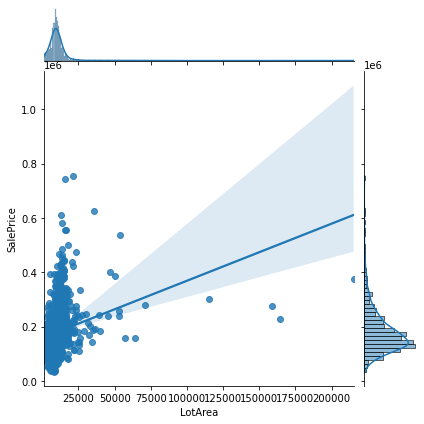

In [16]:
sns.jointplot(train['LotArea'], train['SalePrice'], kind='reg')

In [ ]:
Интересная зависимость, видно, что большой разброс, вероятно свзязанно с соотношением стоимости самого дома, с стоимостью площадью земли. 

### Street

In [17]:
train['Street'].value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

При таком несбалансированном распределении влияние признака будет не существенным. Можно его удалить.

In [18]:
train = train.drop('Street', 1)

### Alley

Слишком мало наблюдений, для нормального заполнения пропущенных значений признака. Удаляем.

In [19]:
train = train.drop('Alley', 1)

### LotShape

In [20]:
train['LotShape'].value_counts()

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

Обработаем, как dummy-переменную.

In [21]:
dummyes_columns = []

In [22]:
dummyes_columns.append('LotShape')

### LandContour

In [23]:
train['LandContour'].value_counts()

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

Можно определить, как бинарный признак, где нормальное расположение это 0, не нормальное 1. Но врядли признак будет иметь больой вес.

In [24]:
train['LandContour'] = (train['LandContour'] != 'Lvl').astype(int)

### Utilities

In [25]:
train['Utilities'].value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

При таком несбалансированном распределении влияние признака будет не существенным. Можно его удалить.

In [26]:
train = train.drop('Utilities', 1)

### LotConfig

In [27]:
train['LotConfig'].value_counts()

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

Слабо понимаю суть признака, просто запишем в список дамми переменных.

In [28]:
dummyes_columns.append('LotConfig')

### LandSlope

In [29]:
train['LandSlope'].value_counts()

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

Снова очень не сбалансированный признак. Попробуем сделать бинарный признак, но врядли будет большая польза.

In [30]:
train['LandSlope'] = (train['LandSlope'] != 'Gtl').astype(int)

### Neighborhood 

In [31]:
train['Neighborhood'].value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

Закодируем частотой.

In [32]:
neighborhood_pop_dict = train['Neighborhood'].value_counts(normalize=True).to_dict()
train.replace({'Neighborhood': neighborhood_pop_dict}, inplace=True )

### Condition1

In [33]:
train['Condition1'].value_counts()

Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64

In [34]:
train['Condition2'].value_counts()

Norm      1445
Feedr        6
RRNn         2
Artery       2
PosN         2
RRAe         1
PosA         1
RRAn         1
Name: Condition2, dtype: int64

In [35]:
train[['Condition1', 'Condition2']]

,Condition1,Condition2
0,Norm,Norm
1,Feedr,Norm
2,Norm,Norm
3,Norm,Norm
4,Norm,Norm
...,...,...
1455,Norm,Norm
1456,Norm,Norm
1457,Norm,Norm
1458,Norm,Norm


In [36]:
train.loc[train['Condition1'] != train['Condition2']]['SalePrice'].mean()

158014.7487179487

На сколько я понял описание признаков, это близость к полезным \ важным точкам. Мы можем создать доп признак, 

In [37]:
train.groupby(by='Condition1')['SalePrice'].mean()

Condition1
Artery    135091.666667
Feedr     142475.481481
Norm      184495.492063
PosA      225875.000000
PosN      215184.210526
RRAe      138400.000000
RRAn      184396.615385
RRNe      190750.000000
RRNn      212400.000000
Name: SalePrice, dtype: float64

### Переменные

class_pop_dict = X_train['MSSubClass'].value_counts(normalize=True).to_dict()
mszoning_mean_price_dict = X_train.groupby(by='MSZoning')['SalePrice'].mean().to_dict()
lotfrontage_mode = X_train['LotFrontage'].mode()[0]

neighborhood_pop_dict = X_train['Neighborhood'].value_counts(normalize=True).to_dict()


In [38]:
def train_prep(df):
   
    df.replace({'MSSubClass': class_pop_dict}, inplace=True )
    df.replace({'MSZoning': mszoning_mean_price_dict}, inplace=True )
    df.loc[df['LotFrontage'].isna(), 'LotFrontage'] = lotfrontage_mode
    df = df.drop('Street', 1)
    df = df.drop('Alley', 1)
    df['LandSlope'] = (df['LandSlope'] != 'Gtl').astype(int)
    df.replace({'Neighborhood': neighborhood_pop_dict}, inplace=True )
    return df